## 0. Paquetes

In [1]:
import numpy as np
import pandas as pd
import random
from pickle import dump
import matplotlib.pyplot as plt
# from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import ParameterGrid
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten, Reshape, Conv1D
from keras.preprocessing.sequence import TimeseriesGenerator 
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import seaborn as sns
from numpy import array
from sklearn.impute import KNNImputer
import datetime
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
import os

Num GPUs Available:  0


In [2]:
assert tf.test.is_built_with_cuda()
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

## 1. Importar y pre-procesar base

In [3]:
df = pd.read_excel("4_itbmpp_x_semana.xlsx")
Yu = df[["WEEK", "ITMBPP_PCT"]].dropna()
Yu = Yu.set_index("WEEK")
Yu.columns = ["q"]

## 2. Model

### 2.1 Split and arrange data

In [38]:
# Parámetros generales
Yu = Yu[["q"]] # Seleccionar la columna "q" del DataFrame Yu
train_size  = 0.96  # Porcentaje de datos para el conjunto de entrenamiento
val_size    = 1 - train_size  # Porcentaje de datos para el conjunto de validación
n_lag       = 5     # Número de pasos de tiempo (lags) a considerar en el pasado
n_features  = Yu.shape[1]     # Número de características (en este caso, solo una)
MAX_EPOCHS  = 100    # Número máximo de épocas para el entrenamiento
len_batch   = 1  # Tamaño del lote (batch size)

# Dividir datos en conjuntos de entrenamiento, validación y prueba
n = len(Yu)
train = Yu[0:int(n * train_size)] 
val = Yu[int(n * train_size):int(n*(train_size + val_size))]
test = Yu[int(n*(train_size + val_size)):]

# Imprimir cantidad de observaciones en cada conjunto
print("Observaciones:")
print("Total:", len(Yu))
print("Entrenamiento:", len(train), f"({round(len(train)/len(Yu)*100,1)}%)")
print("Validación:", len(val), f"({round(len(val)/len(Yu)*100,1)}%)")
print("Prueba:", len(test), f"({round(len(test)/len(Yu)*100,1)}%)", "\n")

# Estandarizar los datos utilizando StandardScaler
scaler_y = StandardScaler()
scaler_y.fit(train)
Ys_train = scaler_y.transform(train)
Ys_val = scaler_y.transform(val)
Ys_all = scaler_y.transform(Yu)

# Crear generadores de series temporales para entrenamiento, validación y todos los datos
ts_trai_uni = TimeseriesGenerator(Ys_train, Ys_train, length=n_lag, batch_size=len_batch, shuffle= False)
ts_vali_uni = TimeseriesGenerator(Ys_val, Ys_val, length=n_lag, batch_size=len_batch, shuffle= False)
ts_all_uni = TimeseriesGenerator(Ys_all, Ys_all, length=n_lag, batch_size=len_batch, shuffle= False)

# Diccionarios para almacenar los resultados del desempeño del modelo
vali_performance = {}
trai_performance= {}

# Acceder al primer elemento del conjunto de validación
val.iloc[0]

Observaciones:
Total: 206
Entrenamiento: 197 (95.6%)
Validación: 9 (4.4%)
Prueba: 0 (0.0%) 



q    0.268841
Name: 2022-10-17 00:00:00, dtype: float64

### 2.1 Model estimation

In [39]:
max_lr, max_b1, max_b2, max_e = 0.00022387211385683378, 0.9, 0.9999, 1e-07

In [40]:
#### Parametros

tf.random.set_seed(2)
os.environ['PYTHONHASHSEED']=str(2)
tf.keras.utils.set_random_seed(2)

#Early stop
paciencia = 20
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=paciencia, mode='min') #Early Stop

#Model parameters
perdida = tf.losses.MeanSquaredError()
metrica = [tf.metrics.MeanAbsoluteError(), tf.metrics.MeanAbsolutePercentageError(), tf.losses.MeanSquaredError()]

#Optimizer

param_opt = {
    "learning_rate": max_lr,
    "beta_1" : max_b1,
    "beta_2" : max_b2,
    "epsilon": max_e}

optimizer_adam = tf.optimizers.Adam()

#### Modelo 
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(n_lag, n_features), return_sequences= True))
model.add(LSTM(32, activation='relu', input_shape=(n_lag, n_features)))
model.add(Dense(30))
model.add(Dense(1))

model.compile(loss=tf.keras.losses.Huber(), 
        optimizer=optimizer_adam, 
        metrics=metrica)


#### Model building
history = model.fit(ts_trai_uni, 
    validation_data = ts_vali_uni,  
    epochs=MAX_EPOCHS, 
    verbose=0,
    callbacks = [])

## 3. Desempeño modelo

#### 3.1 Prediccion 1-paso y n-pasos fuera de entrenamiento

In [43]:
# Calcular el desempeño del modelo en conjuntos de entrenamiento y validación
trai_performance["UNIV"] = scaler_y.inverse_transform(array(model.evaluate(ts_trai_uni, verbose = 0)[1]).reshape(-1,1))
vali_performance["UNIV"] = scaler_y.inverse_transform(array(model.evaluate(ts_vali_uni, verbose = 0)[1]).reshape(-1,1))
# Imprimir resultados de desempeño
print(trai_performance, vali_performance)

# Preparar datos iniciales para predicciones multistep
X_ini = Ys_all[-(len(Ys_val) + n_lag): ][:n_lag]
X_ini = X_ini.reshape(n_features, n_lag, n_features)

# Realizar predicciones multistep iterativamente
for i in range(len(Ys_val)):
    Y_pred = model.predict(X_ini[:, i : n_lag+i+1, :], verbose=0)
    X_ini = np.append(X_ini, Y_pred).reshape(n_features, len(X_ini[0])+1, n_features)

# Eliminar datos innecesarios y aplicar transformación inversa
X_ini = X_ini[0][n_lag:]
pred_p = scaler_y.inverse_transform(X_ini)

# Alinear índices temporales de predicciones multistep
b = np.empty((len(Ys_train),1,))
b[:] = np.nan
pred_p = np.concatenate((b, pred_p), axis = 0)
pred_p = pred_p.reshape(-1)

# Realizar predicciones onestep en todos los datos
yhat_all = model.predict(ts_all_uni, verbose=0)
yhat_all_level = scaler_y.inverse_transform(yhat_all)

# Alinear índices temporales de predicciones onestep
a = np.empty((n_lag,1,))
a[:] = np.nan
yhat_all_level = np.concatenate((a, yhat_all_level),axis = 0)

# Obtener valores observados en escala original
yobs_test_level = scaler_y.inverse_transform(Ys_all)

# Crear DataFrame con valores observados y predicciones
preds = pd.DataFrame(zip(yobs_test_level.reshape(len(yobs_test_level)), yhat_all_level.reshape(len(yhat_all_level)), pred_p),
            index = Yu.index,
            columns = ["OBSERVADO", "PREDICHO_ONESTEP", "PREDICHO_PRED"])

{'UNIV': array([[0.06408025]])} {'UNIV': array([[0.07921289]])}


#### 3.2 ¿Como luce?

<ipython-input-44-c8bff040392d>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


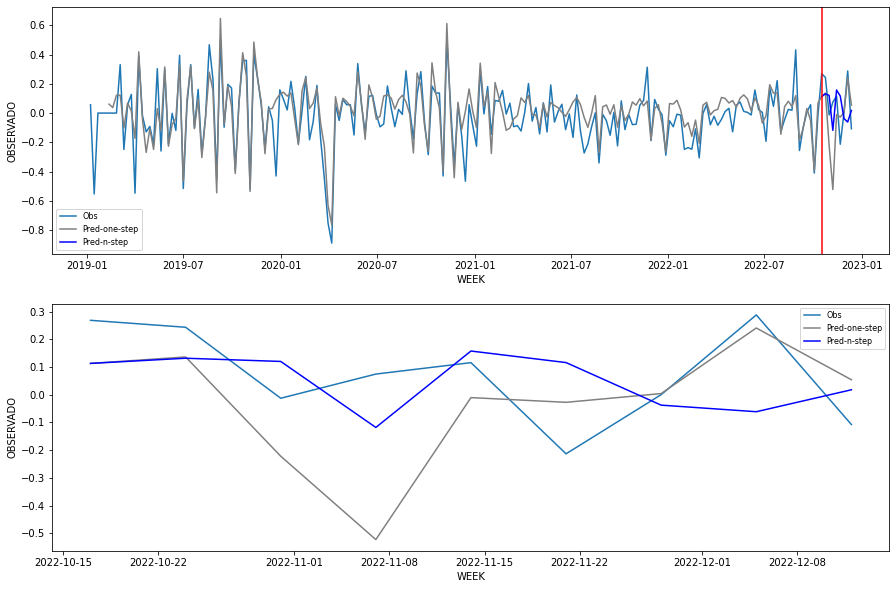

In [44]:
# VISUALIZAR
fig, ax =plt.subplots(2,1, figsize=(15, 10), sharex = False)

#PRIMERA GRÁFICA
sns.lineplot(x=preds.index, y=preds.OBSERVADO, ax = ax[0])
sns.lineplot(x=preds.index, y=preds.PREDICHO_ONESTEP, color = "gray", ax = ax[0])
sns.lineplot(x=preds.index, y=preds.PREDICHO_PRED, color = "blue", ax = ax[0])

ax[0].axvline(x=preds.index[int(n * train_size)], color='red')
ax[0].legend(labels=['Obs', 'Pred-one-step', 'Pred-n-step'], prop={'size': 8})
# ax[0].axis(ymin= 20015.12, ymax= 970278.39)


#SEGUNDA GRÁFICA
sns.lineplot(x=preds.index[int(n * train_size):][0:30], y=preds.OBSERVADO[int(n * train_size):][0:30], ax = ax[1])
sns.lineplot(x=preds.index[int(n * train_size):][0:30], y=preds.PREDICHO_ONESTEP[int(n * train_size):][0:30], color = "gray", ax = ax[1])
sns.lineplot(x=preds.index[int(n * train_size):][0:30], y=preds.PREDICHO_PRED[int(n * train_size):][0:30], color = "blue", ax = ax[1])

ax[1].legend(labels=['Obs', 'Pred-one-step', 'Pred-n-step'], prop={'size': 8})
# ax[1].axis(ymin= 320015.12, ymax= 970278.39)


fig.show()

## 4. Guardar modelo

In [5]:
from tensorflow.keras.models import load_model
import joblib

In [45]:
model.save("modelos/model1.h5") #GUARDAR MODELO
joblib.dump(scaler_y, "modelos/scaler1.gz") #GUARDAR SCALER

['modelos/scaler1.gz']

In [6]:
# CARGAR MODELO
my_scaler = joblib.load("modelos/scaler1.gz") #SCALER
model_load = load_model("modelos/model1.h5", compile=False) #MODELO
lags = model_load.input_shape[1]

In [7]:
# FUNCIÓN DE PREDICCIÓN DEL MODELO
def pred(df, model, scalerm, periodos_pred = 8):

    """
    Forecast recursive prediction using Keras model. 
    
    Parameters
    ---------------
    df: Dataframe object of observed values with index as date and one column with data.
    model: Pretrained model used for predition.
    scalerm: Scaler used during training.
    periodos_pred: number periods (weeks) a predecir
    """

    pronostico_niveles = [df.iloc[-1][0]]
    
    #Pre-procesamiento de los datos
    lags = model.input_shape[1] #numero_lags
    df = df.pct_change()*100
    df = df.dropna()
    Ys_all = scalerm.transform(df) #transformar la serie

    #Reshap de la serie para la lectura del modeo
    Y_ph = Ys_all[-lags:] 
    Y_ph = Y_ph.reshape(1, lags, 1)

    #Rango de fechas (semanas)
    week_1 = df.index[-1] + datetime.timedelta(days=7)
    week_f = week_1 + datetime.timedelta(weeks=periodos_pred)
    range_date = pd.date_range(start= week_1, end= week_f, freq = "W-MON")

    #Predicción
    for i in range(len(range_date)):
        Y_pred = model.predict(Y_ph[:, i : lags+i+1, :], verbose=0)
        Y_ph = np.append(Y_ph, Y_pred).reshape(1, len(Y_ph[0])+1, 1)

    #Re-escalar (traer a cambios porcentuales)
    Y_ph = scalerm.inverse_transform(Y_ph[0][lags:])
    pronostico_variacion = Y_ph.reshape(len(Y_ph))
    

    #Traer a niveles
    for i in range(len(pronostico_variacion)):
        ynsetp = (pronostico_variacion[i]/100 + 1)*pronostico_niveles[i]
        pronostico_niveles.append(ynsetp)

    #Predicciones y eje (fecha)
    predictions = pronostico_niveles[1:]
    prediction_xaxis = []

    for i in range(len(range_date)):
        k = str(range_date[i])[0:10]
        prediction_xaxis.append(k)
        

    return dict(zip(prediction_xaxis, list(predictions)))
    # return predictions

## 5. ¿Como luce fuera de muestra en niveles?

In [8]:
D = df[["WEEK", "ITMBPP"]]
P = pred(D.set_index("WEEK"), model_load, my_scaler, periodos_pred = 30)
P = pd.DataFrame(list(P.items()), columns=["WEEK", "ITMBPP"])
G = pd.concat([D,P])

c:\Users\War\anaconda3\lib\site-packages\sklearn\base.py:488: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- ITMBPP
Feature names seen at fit time, yet now missing:
- q

  warnings.warn(message, FutureWarning)


In [9]:
G = pd.concat([D,P])
G['WEEK'] = pd.to_datetime(G['WEEK'])

<ipython-input-10-ce797041ed18>:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


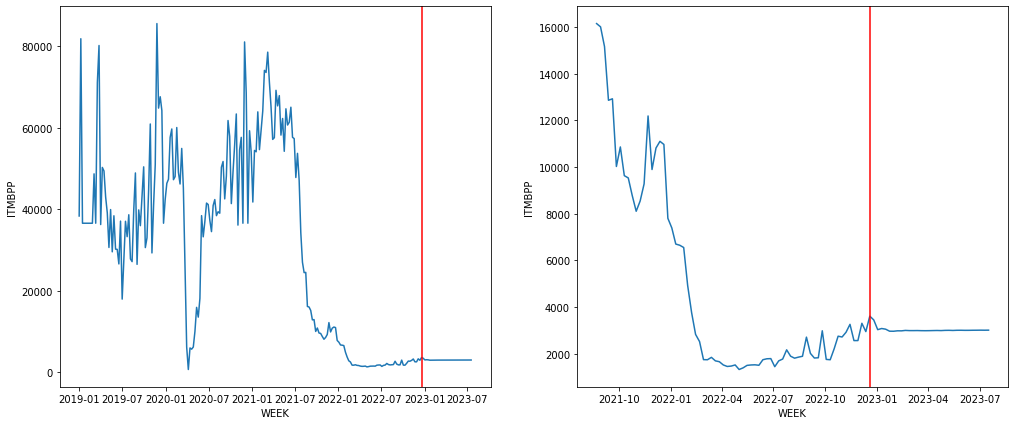

In [10]:
# VISUALIZAR
fig, ax =plt.subplots(1,2, figsize=(17, 7), sharex = False)

DATE_FORECAST = G.iloc[len(G)-len(P)].WEEK

#PRIMERA GRÁFICA
sns.lineplot(x=G.WEEK, y=G.ITMBPP, ax = ax[0])
ax[0].axvline(x=DATE_FORECAST, color='red')

#PRIMERA GRÁFICA
sns.lineplot(x=G.WEEK[len(G)-100:], y=G.ITMBPP[len(G)-100:], ax = ax[1])
ax[1].axvline(x=DATE_FORECAST, color='red')

fig.show()

## 6. PRONOSTICAR EL NUMERO DE EMPRESAS: AR

In [11]:
num = df[["RUC", "WEEK"]]
num = num.set_index("WEEK")
num.columns =  ["q"]

In [290]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
warnings.simplefilter("ignore", ValueWarning)
warnings.simplefilter("ignore", ConvergenceWarning)
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
import pickle
from datetime import timedelta

In [12]:
def percentage_change(df: pd.DataFrame, column_name: str) -> pd.DataFrame:
    df_pct_change = df[column_name].pct_change().dropna()
    return pd.DataFrame(df_pct_change)

def train_and_export_arima(df: pd.DataFrame, filename: str) -> None:
    df = percentage_change(df,"q")
    train_size = int(len(df) * 0.8)
    train_data = df.q[:train_size]
    

    best_model = None
    lowest_mae = float("inf")

    for x in range(1, 11):
        model = ARIMA(train_data, order=(x, 0, 0))
        model_fitted = model.fit()
        
        predictions = model_fitted.predict(start=train_size, end=len(df) - 1, dynamic=False)
        mae = mean_absolute_error(df.q[train_size:], predictions)
        
        if mae < lowest_mae:
            best_model = model_fitted
            lowest_mae = mae
    
    with open(filename, 'wb') as f:
        pickle.dump(best_model, f)

def import_arima_model(filename: str):
    with open(filename, 'rb') as f:
        best_model = pickle.load(f)
    return best_model


def predict_arima_manual(coefs, lags):
    return np.dot(coefs, lags)


def predict_arima_with_new_data(best_model, n_periods: int, new_data: pd.DataFrame) -> dict:
    ar_coefs = best_model.params[1:]
    lags_needed = len(ar_coefs)
    
    # Calcular las variaciones porcentuales
    new_data_pct_change = percentage_change(new_data, 'q')
    new_data_lags = new_data_pct_change.q[-lags_needed:].values

    manual_predictions_pct_change = []
    for _ in range(n_periods):
        prediction_pct_change = predict_arima_manual(ar_coefs, new_data_lags)
        manual_predictions_pct_change.append(prediction_pct_change)
        new_data_lags = np.concatenate((new_data_lags[1:], [prediction_pct_change]))

    # Convertir las predicciones de variaciones porcentuales a niveles
    last_original_value = new_data.q.iloc[-1]
    manual_predictions = [last_original_value * (1 + prediction) for prediction in manual_predictions_pct_change]

    # Crear el diccionario con fechas y valores de predicción
    start_date = new_data.index[-1] + timedelta(days=1)
    while start_date.weekday() != 0:  # Asegurar que la fecha de inicio sea un lunes
        start_date += timedelta(days=1)

    prediction_dates = pd.date_range(start_date, periods=n_periods, freq='W-MON')
    predictions_dict = {date: value for date, value in zip(prediction_dates, manual_predictions)}

    return predictions_dict

In [14]:
# train_and_export_arima(num, 'best_arima_model.pkl')
# modelor = import_arima_model('best_arima_model.pkl')

In [317]:
D = df[["WEEK", "RUC"]]
P = predict_arima_with_new_data(modelor, 31, num)
P = pd.DataFrame(list(P.items()), columns=["WEEK", "RUC"])
P["RUC"] =model.predict(n_periods=31)
G2 = pd.concat([D,P])
GF = pd.merge(G,G2, "inner", "WEEK")
GF["ITMBS"]  = GF["ITMBPP"]*GF["RUC"]

<ipython-input-320-9975334bf17e>:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


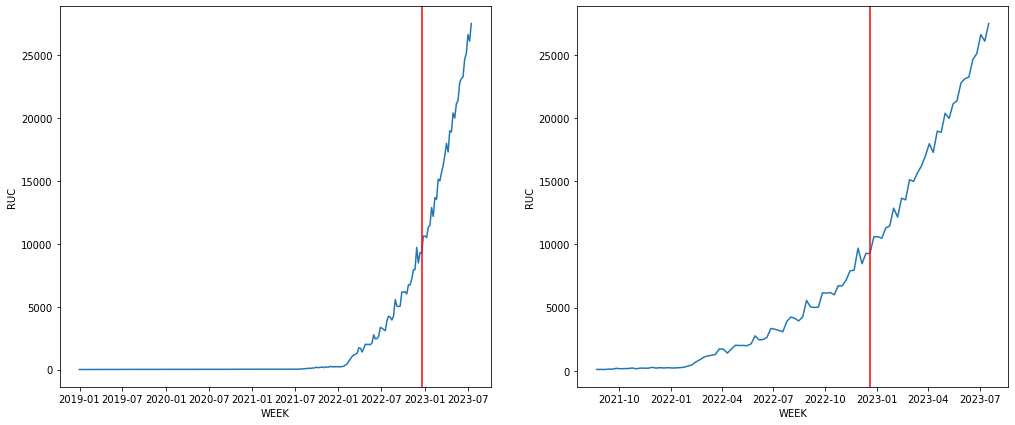

In [320]:
# VISUALIZAR
fig, ax =plt.subplots(1,2, figsize=(17, 7), sharex = False)

DATE_FORECAST = GF.iloc[len(G)-len(P)].WEEK

#PRIMERA GRÁFICA
sns.lineplot(x=GF.WEEK, y=GF.RUC, ax = ax[0])
ax[0].axvline(x=DATE_FORECAST, color='red')

#PRIMERA GRÁFICA
sns.lineplot(x=GF.WEEK[len(G)-100:], y=GF.RUC[len(G)-100:], ax = ax[1])
ax[1].axvline(x=DATE_FORECAST, color='red')

fig.show()

<ipython-input-321-28b3571ac217>:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


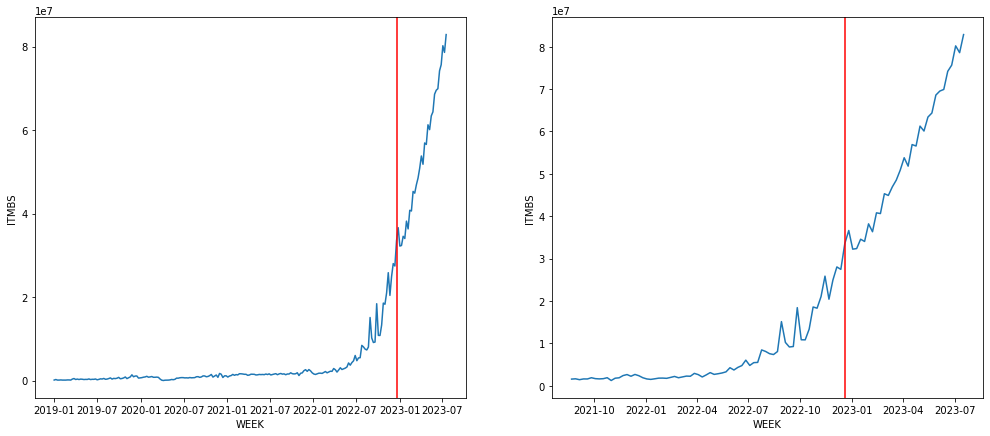

In [321]:
# VISUALIZAR
fig, ax =plt.subplots(1,2, figsize=(17, 7), sharex = False)

DATE_FORECAST = GF.iloc[len(G)-len(P)].WEEK

#PRIMERA GRÁFICA
sns.lineplot(x=GF.WEEK, y=GF.ITMBS, ax = ax[0])
ax[0].axvline(x=DATE_FORECAST, color='red')

#PRIMERA GRÁFICA
sns.lineplot(x=GF.WEEK[len(G)-100:], y=GF.ITMBS[len(G)-100:], ax = ax[1])
ax[1].axvline(x=DATE_FORECAST, color='red')

fig.show()

## 6. PRONOSTICAR EL NUMERO DE EMPRESAS (PRONOSTICO DE TENDENCIA)

In [349]:
num = df[["RUC", "WEEK"]].iloc[:]
num = num.set_index("WEEK")
num.columns =  ["q"]

C:\Users\War\AppData\Roaming\Python\Python38\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,1,1)[52]             : AIC=inf, Time=62.71 sec
 ARIMA(0,2,0)(0,1,0)[52]             : AIC=2295.197, Time=0.46 sec
 ARIMA(1,2,0)(1,1,0)[52]             : AIC=2212.985, Time=5.24 sec
 ARIMA(0,2,1)(0,1,1)[52]             : AIC=inf, Time=18.23 sec
 ARIMA(1,2,0)(0,1,0)[52]             : AIC=2211.243, Time=1.64 sec
 ARIMA(1,2,0)(0,1,1)[52]             : AIC=2212.980, Time=11.49 sec
 ARIMA(1,2,0)(1,1,1)[52]             : AIC=2214.984, Time=12.28 sec
 ARIMA(2,2,0)(0,1,0)[52]             : AIC=2199.830, Time=1.26 sec
 ARIMA(2,2,0)(1,1,0)[52]             : AIC=2201.616, Time=7.88 sec
 ARIMA(2,2,0)(0,1,1)[52]             : AIC=2201.617, Time=7.65 sec
 ARIMA(2,2,0)(1,1,1)[52]             : AIC=2203.616, Time=13.42 sec
 ARIMA(3,2,0)(0,1,0)[52]             : AIC=inf, Time=9.65 sec
 ARIMA(2,2,1)(0,1,0)[52]             : AIC=inf, Time=16.74 sec
 ARIMA(1,2,1)(0,1,0)[52]             : AIC=inf, Time=9.48 sec
 ARIMA(3,2,1)(0,1,0)[52]             :

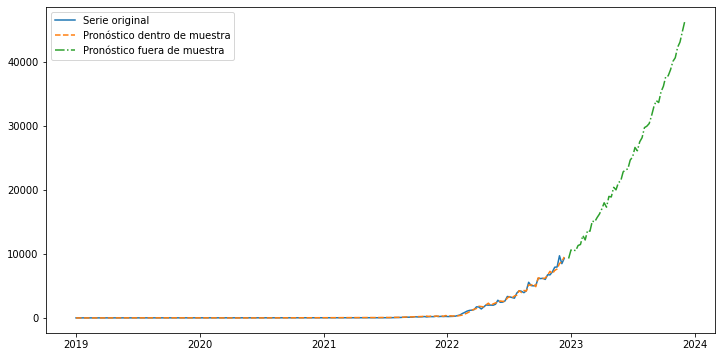

In [306]:
import pmdarima as pm

# Estimar el modelo SARIMAX
model = pm.auto_arima(num['q'], seasonal=True, m=52, trend='ct',
                      stepwise=True, suppress_warnings=True,
                      trace=True, n_jobs=-1, error_action='ignore')

# Mostrar los parámetros del mejor modelo
print("\nMejor modelo SARIMAX:")
print(model.summary())

# Predecir valores con el modelo dentro de muestra
in_sample_preds = model.predict_in_sample()
in_sample_preds = pd.Series(in_sample_preds, index=num.index)

# Predecir valores con el modelo fuera de muestra
n_steps = 50  # Define aquí la cantidad de pasos hacia adelante que deseas pronosticar
out_of_sample_preds = model.predict(n_periods=n_steps)
pred_index = pd.date_range(start=num.index[-1] + pd.Timedelta(weeks=1), periods=n_steps, freq='W')
out_of_sample_preds = pd.Series(out_of_sample_preds, index=pred_index)

# Visualizar los resultados
plt.figure(figsize=(12, 6))
plt.plot(num['q'], label='Serie original')
plt.plot(in_sample_preds, label='Pronóstico dentro de muestra', linestyle='--')
plt.plot(out_of_sample_preds, label='Pronóstico fuera de muestra', linestyle='-.')
plt.legend()
plt.show()                                                                                                                                                                                                             

In [322]:
import pickle

# Guardar el modelo en un archivo
with open('model2.pkl', 'wb') as pkl_file:
    pickle.dump(model, pkl_file)

In [337]:
with open('model2.pkl', 'rb') as pkl_file:
    loaded_model = pickle.load(pkl_file)

In [356]:
def sarimax_prediction(model, periods, last_date):

    # Obtener las fechas de los pasos hacia adelante a pronosticar
    last_date  = last_date + datetime.timedelta(days=7)
    pred_index = pd.date_range(last_date, periods=periods, freq='W-MON')

    # Realizar la predicción de los pasos hacia adelante
    pred = model.predict(n_periods=periods)

    # Crear un diccionario con las fechas de la predicción como llave y la predicción como valor
    pred_dict = {str(date.date()): pred[i] for i, date in enumerate(pred_index)}

    return pred_dict
    # return pred_index, pred

In [362]:
D = df[["WEEK", "RUC"]]
P = sarimax_prediction(loaded_model, 31, num.index[-1])
P = pd.DataFrame(list(P.items()), columns=["WEEK", "RUC"])
G2 = pd.concat([D,P])
G2['WEEK'] = pd.to_datetime(G2['WEEK'])
GF = pd.merge(G,G2, "inner", "WEEK")
GF["ITMBS"]  = GF["ITMBPP"]*GF["RUC"]

<ipython-input-363-9975334bf17e>:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


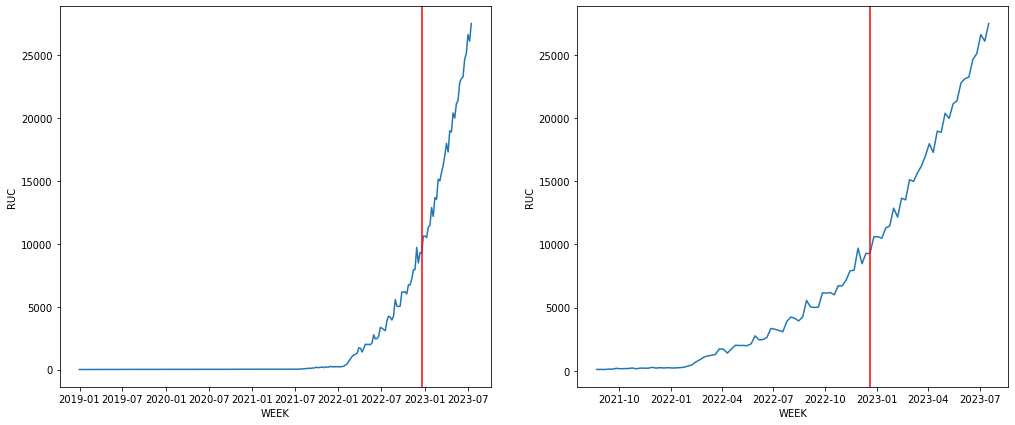

In [363]:
# VISUALIZAR
fig, ax =plt.subplots(1,2, figsize=(17, 7), sharex = False)

DATE_FORECAST = GF.iloc[len(G)-len(P)].WEEK

#PRIMERA GRÁFICA
sns.lineplot(x=GF.WEEK, y=GF.RUC, ax = ax[0])
ax[0].axvline(x=DATE_FORECAST, color='red')

#PRIMERA GRÁFICA
sns.lineplot(x=GF.WEEK[len(G)-100:], y=GF.RUC[len(G)-100:], ax = ax[1])
ax[1].axvline(x=DATE_FORECAST, color='red')

fig.show()

<ipython-input-364-28b3571ac217>:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


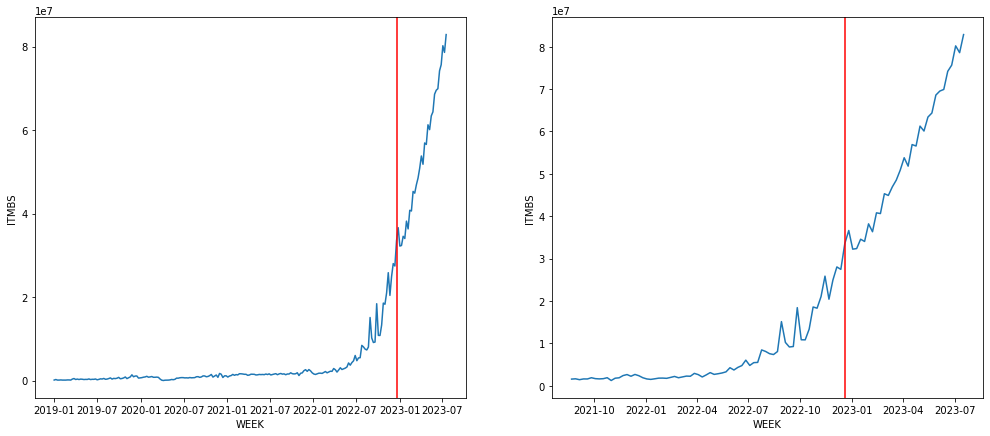

In [364]:
# VISUALIZAR
fig, ax =plt.subplots(1,2, figsize=(17, 7), sharex = False)

DATE_FORECAST = GF.iloc[len(G)-len(P)].WEEK

#PRIMERA GRÁFICA
sns.lineplot(x=GF.WEEK, y=GF.ITMBS, ax = ax[0])
ax[0].axvline(x=DATE_FORECAST, color='red')

#PRIMERA GRÁFICA
sns.lineplot(x=GF.WEEK[len(G)-100:], y=GF.ITMBS[len(G)-100:], ax = ax[1])
ax[1].axvline(x=DATE_FORECAST, color='red')

fig.show()